In [74]:
def determine(lst):
    return (all(x == 0.0 for x in lst))

def check_zeros(data):
    new_data = []
    for i in data:
        if not determine(i[1]):
            if new_data == None:
                new_data = i
            else:
                new_data.append(i)
#     data = [i for i in data if not determine(i[1])]
#     for item in data[:]:
#         if sum(item[1]) == 0:
#             data.pop(data.index(item))
    # for i, value in enumerate(data.copy()):
    #     if sum(value[1]) == 0:
    #         data.pop(i)
    return new_data


def merge_amino_nuc(amino, nuc):
    final_df = nuc
    return final_df.join(amino.iloc[:, :2].set_index('pid'), on='pid', how='inner')


#get all the data from a specific order
def get_data_order(data, order_name):
    new_data = []

    if (order_name == 'Coleoptera'):
        index_one = 0
    elif (order_name == 'Diptera'):
        index_one = 1
    elif (order_name == 'Hymenoptera'):
        index_one = 2
    elif (order_name == 'Lepidoptera'):
        index_one = 3
    
    for i in range(len(data)):
        code_order = data[i][2][index_one]
        if(code_order == 1):
            data[i][2] = [1,0]
        else:
            data[i][2] = [0,1]
        new_data.append(data[i])
            
    return new_data

def read_pids_fasta(file_fasta):
    pids = []
    for record in SeqIO.parse(file_fasta, "fasta"):
        record_id = record.id
        pids.append(record_id.split("|")[0])        
    return pids

def save_object(obj, filename):
    with open(filename, 'wb') as output:  
        pickle.dump(obj, output, protocol=2)
        
def split_new(data,training_percent):
    training_percent = float(training_percent)
    for i in range(len(data)):
        if i < int(len(data)*training_percent):
            data[i].append(['train'])
        else:
            data[i].append(['test'])
    return data
    
def split(feature_file,training_percent):

    training_percent = float(training_percent)
    
    with open("../feature_data/" + feature_file, 'rb') as file:
        data = pickle.load(file)
        for i in range(len(data)):
            if i < int(len(data)*training_percent):
                data[i].append(['train'])
            else:
                data[i].append(['test'])
        return data
        #save_object(data, "train_and_test/tt-" + str(training_percent) + "-" + feature_file)

def build_DNN(train_x,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net = tflearn.input_data(shape=[None, len(train_x[0])])
    # Two fully connected layers with 8 hidden units/neurons - optimal for this task
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, 4,activation='softmax')
    # number of intents, columns in the matrix train_y
    #net = tflearn.fully_connected(net, len(train_y[0]), activation='softmax')
    # regression to find best parameters, during training
    net = tflearn.regression(net)

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_sequence_logs')
    return modell

def build_DNN_Arch1(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
    net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch1_logs', tensorboard_verbose=3)
    return model

def build_DNN_Arch2(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
#     net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch2_logs', tensorboard_verbose=3)
    return model

def train_DNN(model, train_x,train_y,classes):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit(train_x, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model.save('model/'+classes[0]+'_'+classes[1]+'.tflearn')

def train_DNN_arch12(model, train_aa, train_nu, train_y,classe,arch,grp):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit({"InputData0":train_aa,"InputData1":train_nu}, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model_name = 'model/'+classe+'_block_'+grp+'_'+arch+'.tflearn'
    model.save(model_name)
    return model_name
    
def predict_old(frequency,model,classes):

    ERROR_THRESHOLD = 0.5
    
    # generate probabilities from the model
    results = model.predict(frequency)[0]

    # filter out predictions below a threshold, and provide intent index
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append(classes[r[0]])
    
    return return_list

def predict(model, test_aa, test_nu,classes):
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]

    new_results = results
    if results[0] > results[1]:
        #new_results[0] = results[0]
        #new_results[1] = results[1]
        class_result = 0
    else:
        #new_results[0] = results[1]
        #new_results[1] = results[0]
        class_result = 1

    #return_list = []
    #return_list.append((classes[class_result], str(new_results[0])))
    return classes[class_result], float(results[0]), float(results[1])

def predict_with_threshold(model, test_aa, test_nu,classes):
    
    THRESHOLD = 0.5
        
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]
    
    if(results[0] >= THRESHOLD):
        class_index = 0 #The first class is the positive class
    else:
        class_index = 1 

    return classes[class_index], results[0]

def fix_format(string):
    return re.sub('[\[\]\']','',string)

def plot_roc(y_test,y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = array(y_test)
    y_score = array(y_score)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def metrics_DNN(predict_y,id_test,test_y,classes,scores):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    id_misclassified = []
    pred_misclassified = []
    y_misclassified = []
    
    #class[0] is the positive class, test_y == 1 is the positive class
    for i in range(len(predict_y)):
        if (predict_y[i] == classes[0] and test_y[i] == 1):
            true_positive += 1
            
        elif (predict_y[i] == classes[1] and test_y[i] == 0):
            true_negative += 1
            
        elif(predict_y[i] == classes[1] and test_y[i] == 1):
            false_negative += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[0])
            
        elif(predict_y[i] == classes[0] and test_y[i] == 0):
            false_positive += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[1])
    
    
    df_misclassified = pd.DataFrame({'id': id_misclassified,'predicted': pred_misclassified,'real_class': y_misclassified})
            
    precision_classe0 = float(true_positive)/(true_positive + false_positive)
    sensitivity = float(true_positive)/(true_positive + false_negative) #recall for class0
    F1_score_class0 = 2*(float(precision_classe0*sensitivity)/(precision_classe0 + sensitivity))
    
    precision_classe1 = float(true_negative)/(true_negative + false_negative)
    specificity = float(true_negative)/(false_positive + true_negative)#recall for class1
    F1_score_class1 = 2*(float(precision_classe1*specificity)/(precision_classe1 + specificity))
    
    accuracy = float(true_positive + true_negative)/len(predict_y)
    
    print("Class " + classes[0] +":")
    print("Precision: " + str(precision_classe0))
    print("Sensitivity: " + str(sensitivity))
    print("F1 score: " + str(F1_score_class0))
    
    print("")
    
    print("Class " + classes[1] +":")
    print("Precision: " + str(precision_classe1))
    print("Specificity: " + str(specificity))
    print("F1 score: " + str(F1_score_class1))
    
    print("")
    
    print("Accuracy:")
    print(accuracy)

    plot_roc(test_y,scores)
    
    return df_misclassified

In [2]:
def get_train_test_data(nu_list,aa_list):
    index_pid = 0
    index_x = 1
    index_y = 2
    index_label = 3
    train_aa_x = [] 
    train_nu_x = []
    data_y_train = [] 
    test_aa_x = []
    test_nu_x = []
    data_y_test = []
    pids_test = []
    
    for i in range(len(nu_list)):
        if ((nu_list[i][index_label][0]) == 'train'):
            train_nu_x.append(nu_list[i][index_x])
            data_y_train.append(nu_list[i][index_y])
        else:
            test_nu_x.append(nu_list[i][index_x])
            data_y_test.append(nu_list[i][index_y])
            pids_test.append(nu_list[i][index_pid])
            
    for i in range(len(aa_list)):
        if ((aa_list[i][index_label][0]) == 'train'):
            train_aa_x.append(aa_list[i][index_x])
        else:
            test_aa_x.append(aa_list[i][index_x])
            
    return train_aa_x, train_nu_x, data_y_train, test_aa_x, test_nu_x, data_y_test, pids_test

In [3]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [4]:
def combination_1(scores_pos, scores_neg,classes):
    avr_pos = Average(scores_pos)
    avr_neg = Average(scores_neg)
    
    if (avr_pos >= avr_neg):
        return classes[0], avr_pos
    else:
        return classes[1], avr_pos #always return the positive probability

In [5]:
import numpy as np
import tflearn
import tensorflow as tf
import random
import pickle
from collections import Counter
from sklearn.model_selection import KFold, cross_val_score
import argparse
import pandas as pd
import re
from sklearn.metrics import roc_curve, auc
from numpy import array
import matplotlib.pyplot as plt

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
classes = ['Lepidoptera', 'not_Lepidoptera']

nuc_data_first = {}
nuc_data_second = {}
nuc_data_third = {}
nuc_data_fourth = {}
amino_data_first = {}
amino_data_second = {}
amino_data_third = {}
amino_data_fourth = {}


with open("ensemble_data/1nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_first = pickle.load(file)
    #print(nuc_data_first[0])
with open("ensemble_data/2nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_second = pickle.load(file)
    #print(nuc_data_second[0])
with open("ensemble_data/3nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_third = pickle.load(file)
    #print(nuc_data_third[0])
with open("ensemble_data/4nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_fourth = pickle.load(file)
    #print(nuc_data_fourth[0])
with open("ensemble_data/1aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_first = pickle.load(file)
    #print(amino_data_first[0])
with open("ensemble_data/2aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_second = pickle.load(file)
    #print(amino_data_second[0])
with open("ensemble_data/3aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_third = pickle.load(file)
    #print(amino_data_third[0])
with open("ensemble_data/4aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_fourth = pickle.load(file)
    #print(amino_data_fourth[0])

In [8]:
print(len(nuc_data_first))
print(len(nuc_data_second))
print(len(nuc_data_third))
print(len(nuc_data_fourth))
print(len(amino_data_first))
print(len(amino_data_second))
print(len(amino_data_third))
print(len(amino_data_fourth))

353340
353539
354195
347431
353023
339718
348800
253134


In [9]:
nuc_data_first_lepidoptera = check_zeros(nuc_data_first)
nuc_data_second_lepidoptera = check_zeros(nuc_data_second)
nuc_data_third_lepidoptera = check_zeros(nuc_data_third)
nuc_data_fourth_lepidoptera = check_zeros(nuc_data_fourth)
amino_data_first_lepidoptera = check_zeros(amino_data_first)
amino_data_second_lepidoptera = check_zeros(amino_data_second)
amino_data_third_lepidoptera = check_zeros(amino_data_third)
amino_data_fourth_lepidoptera = check_zeros(amino_data_fourth)

In [10]:
for i in amino_data_fourth_lepidoptera:
    if determine(i[1]):
        print(i)

In [ ]:
"""
print(len(nuc_data_first_lepidoptera))
print(len(nuc_data_second_lepidoptera))
print(len(nuc_data_third_lepidoptera))
print(len(nuc_data_fourth_lepidoptera))
print(len(amino_data_first_lepidoptera))
print(len(amino_data_second_lepidoptera))
print(len(amino_data_third_lepidoptera))
print(len(amino_data_fourth_lepidoptera))
"""

In [11]:
nuc_data_first_lepidoptera = get_data_order(nuc_data_first_lepidoptera, classes[0])
nuc_data_second_lepidoptera = get_data_order(nuc_data_second_lepidoptera, classes[0])
nuc_data_third_lepidoptera = get_data_order(nuc_data_third_lepidoptera, classes[0])
nuc_data_fourth_lepidoptera = get_data_order(nuc_data_fourth_lepidoptera, classes[0])
amino_data_first_lepidoptera = get_data_order(amino_data_first_lepidoptera, classes[0])
amino_data_second_lepidoptera = get_data_order(amino_data_second_lepidoptera, classes[0])
amino_data_third_lepidoptera = get_data_order(amino_data_third_lepidoptera, classes[0])
amino_data_fourth_lepidoptera = get_data_order(amino_data_fourth_lepidoptera, classes[0])

In [12]:
nuc_data_1 =   pd.DataFrame(data = nuc_data_first_lepidoptera,    columns=['pid', 'ndata_x1', 'data_y1'])
nuc_data_2 =   pd.DataFrame(data = nuc_data_second_lepidoptera,   columns=['pid', 'ndata_x2', 'data_y2'])
nuc_data_3 =   pd.DataFrame(data = nuc_data_third_lepidoptera,    columns=['pid', 'ndata_x3', 'data_y3'])
nuc_data_4 =   pd.DataFrame(data = nuc_data_fourth_lepidoptera,   columns=['pid', 'ndata_x4', 'data_y4'])
amino_data_1 = pd.DataFrame(data = amino_data_first_lepidoptera,  columns=['pid', 'adata_x1', 'data_y1'])
amino_data_2 = pd.DataFrame(data = amino_data_second_lepidoptera, columns=['pid', 'adata_x2', 'data_y2'])
amino_data_3 = pd.DataFrame(data = amino_data_third_lepidoptera,  columns=['pid', 'adata_x3', 'data_y3'])
amino_data_4 = pd.DataFrame(data = amino_data_fourth_lepidoptera, columns=['pid', 'adata_x4', 'data_y4'])

In [13]:
final_df_1 = merge_amino_nuc(amino_data_1, nuc_data_1)
final_df_2 = merge_amino_nuc(amino_data_2, nuc_data_2)
final_df_3 = merge_amino_nuc(amino_data_3, nuc_data_3)
final_df_4 = merge_amino_nuc(amino_data_4, nuc_data_4)

In [19]:
print(len(final_df_1))
print(len(final_df_2))
print(len(final_df_3))
print(len(final_df_4))

82194
319077
299054
220625


In [20]:
#get split data from block 1
nu_list_1 = final_df_1[['pid','ndata_x1','data_y1']].values.tolist()
aa_list_1 = final_df_1[['pid','adata_x1','data_y1']].values.tolist()
nu_list_1 = split_new(nu_list_1,0.1)
aa_list_1 = split_new(aa_list_1,0.1)

#get split data from block 2
nu_list_2 = final_df_2[['pid','ndata_x2','data_y2']].values.tolist()
aa_list_2 = final_df_2[['pid','adata_x2','data_y2']].values.tolist()
nu_list_2 = split_new(nu_list_2,0.1)
aa_list_2 = split_new(aa_list_2,0.1)

#get split data from block 3
nu_list_3 = final_df_3[['pid','ndata_x3','data_y3']].values.tolist()
aa_list_3 = final_df_3[['pid','adata_x3','data_y3']].values.tolist()
nu_list_3 = split_new(nu_list_3,0.1)
aa_list_3 = split_new(aa_list_3,0.1)

#get split data from block 4
nu_list_4 = final_df_4[['pid','ndata_x4','data_y4']].values.tolist()
aa_list_4 = final_df_4[['pid','adata_x4','data_y4']].values.tolist()
nu_list_4 = split_new(nu_list_4,0.1)
aa_list_4 = split_new(aa_list_4,0.1)

In [21]:
#Get train and test data
train_aa_x_1, train_nu_x_1, data_y_train_1, test_aa_x_1, test_nu_x_1, data_y_test_1, pids_test_1 = get_train_test_data(nu_list_1,aa_list_1)
train_aa_x_2,train_nu_x_2,data_y_train_2, test_aa_x_2, test_nu_x_2, data_y_test_2, pids_test_2 = get_train_test_data(nu_list_2,aa_list_2)
train_aa_x_3,train_nu_x_3,data_y_train_3, test_aa_x_3, test_nu_x_3, data_y_test_3, pids_test_3 = get_train_test_data(nu_list_3,aa_list_3)
train_aa_x_4,train_nu_x_4,data_y_train_4, test_aa_x_4, test_nu_x_4, data_y_test_4, pids_test_4 = get_train_test_data(nu_list_4,aa_list_4)


In [22]:
pids_test = list(set(pids_test_1 + pids_test_2 + pids_test_3 + pids_test_4))

# Train

In [23]:
%%time
#Train

#build architecture
#train block 1
print("Train Block 1")
model1 = build_DNN_Arch1(len(train_aa_x_1[0]), len(train_nu_x_1[0]),data_y_train_1)
model_name1 =train_DNN_arch12(model1, train_aa_x_1, train_nu_x_1, data_y_train_1,classes[0],'1','1')

#train block 2
print("Train Block 2")
model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
model_name2 = train_DNN_arch12(model2, train_aa_x_2, train_nu_x_2, data_y_train_2,classes[0],'1','2')

print("Train Block 3")
#train block 3
model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
model_name3 = train_DNN_arch12(model3, train_aa_x_3, train_nu_x_3, data_y_train_3,classes[0],'1','3')

print("Train Block 4")
#train block 4
model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
model_name4 = train_DNN_arch12(model4, train_aa_x_4, train_nu_x_4, data_y_train_4,classes[0],'1','4')


Training Step: 22064  | total loss: 0.02373 | time: 15.510s
| Adam | epoch: 005 | loss: 0.02373 - acc: 0.9956 -- iter: 22060/22062
Training Step: 22065  | total loss: 0.02185 | time: 15.513s
| Adam | epoch: 005 | loss: 0.02185 - acc: 0.9961 -- iter: 22062/22062
--
INFO:tensorflow:/Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_4_1.tflearn is not in all_model_checkpoint_paths. Manually adding it.
CPU times: user 8min 10s, sys: 1min 25s, total: 9min 36s
Wall time: 7min 24s


In [58]:
def make_df_predictions(model,test_aa_x,test_nu_x,test_y, pids,classes,grp):

    class_list =[]
    scores_pos = []
    scores_neg = []
    for i in range(len(test_aa_x)):
        cls, scr_pos,scr_neg = predict(model, test_aa_x[i], test_nu_x[i],classes)
        class_list.append(cls)
        scores_pos.append(scr_pos)
        scores_neg.append(scr_neg)
        
    df = pd.DataFrame(pids)
    df.columns = ['pid']
    #df = df.assign(order=result)
    
    if(grp == '1'):
        df = df.assign(score_pos1=scores_pos)
        df = df.assign(score_neg1=scores_neg)
        df = df.assign(test_1 = test_y)
    elif(grp == '2'):
        df = df.assign(score_pos2=scores_pos)
        df = df.assign(score_neg2=scores_neg)
        df = df.assign(test_2 = test_y)
    elif(grp == '3'):
        df = df.assign(score_pos3=scores_pos)
        df = df.assign(score_neg3=scores_neg)
        df = df.assign(test_3 = test_y)
    elif(grp == '4'):
        df = df.assign(score_pos4=scores_pos)
        df = df.assign(score_neg4=scores_neg)
        df = df.assign(test_4 = test_y)
    return df

In [59]:
%%time
#make predictions for each group
tf.reset_default_graph() 
model1 = build_DNN_Arch1(len(train_aa_x_1[0]), len(train_nu_x_1[0]),data_y_train_1)
model1.load(model_name1)
df1 = make_df_predictions(model1,test_aa_x_1,test_nu_x_1, data_y_test_1, pids_test_1,classes,'1')

tf.reset_default_graph() 
model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
model2.load(model_name2) 
df2 = make_df_predictions(model2,test_aa_x_2,test_nu_x_2, data_y_test_2, pids_test_2,classes,'2')

tf.reset_default_graph() 
model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
model3.load(model_name3)  
df3 = make_df_predictions(model3,test_aa_x_3,test_nu_x_3, data_y_test_3, pids_test_3,classes,'3')

tf.reset_default_graph() 
model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
model4.load(model_name4)
df4 = make_df_predictions(model4,test_aa_x_4,test_nu_x_4, data_y_test_4, pids_test_4,classes,'4')



INFO:tensorflow:Restoring parameters from /Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_1_1.tflearn
INFO:tensorflow:Restoring parameters from /Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_2_1.tflearn
INFO:tensorflow:Restoring parameters from /Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_3_1.tflearn
INFO:tensorflow:Restoring parameters from /Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_4_1.tflearn
CPU times: user 7min 3s, sys: 54.7 s, total: 7min 58s
Wall time: 6min 2s


In [63]:
df_all

pid  score_pos1  score_neg1  test_1  score_pos2  \
0         GMMDC2376-15    0.012254    0.716656  [0, 1]    0.005941   
1          GMSAD465-13    0.013043    0.713355  [0, 1]         NaN   
2          MYCRO149-15    0.011092    0.721871  [0, 1]    0.011280   
3          TIMES815-17    0.014572    0.707432  [0, 1]         NaN   
4        GBMIN75170-17    0.003831    0.773465  [0, 1]         NaN   
5          GMRUC191-16    0.049149    0.636991  [0, 1]    0.002001   
6         GBMIX1797-15    0.012630    0.715060  [0, 1]         NaN   
7          OPPBE798-17    0.019295    0.692069  [0, 1]    0.005190   
8         BCHYM2072-14    0.012999    0.713537  [0, 1]    0.008487   
9          GMBZS200-16    0.011445    0.720239  [0, 1]    0.004532   
10         SDBEE245-12    0.011329    0.720770  [0, 1]         NaN   
11        GMGGQ2588-17    0.012009    0.717719  [0, 1]    0.013813   
12        GMMGT1617-14    0.005191    0.759475  [0, 1]         NaN   
13         SDBEE278-12    0.012306    0.716431  [0, 1]         NaN   
14          MONO079-16    0.008310    0.736617  [0, 1]    0.000388   
15         GMGAG641-17    0.007294    0.743099  [0, 1]    0.000707   
16        GMOZB1517-17    0.022139    0.684345  [0, 1]    0.000248   
17         GMCDC083-16    0.015883    0.702766  [0, 1]    0.015637   
18         ASILO110-17    0.012472    0.715727  [0, 1]         NaN   
19         ASANI761-11    0.004235    0.768909  [0, 1]         NaN   
20         BEECF487-11    0.009873    0.727886  [0, 1]         NaN   
21        KDIPT1100-13    0.015673    0.703491  [0, 1]         NaN   
22        GMCDK1574-17    0.010970    0.722446  [0, 1]    0.000783   
23        CNGSD8281-15    0.006982    0.745245  [0, 1]    0.000128   
24         HYAS1403-12    0.014127    0.709094  [0, 1]    0.011837   
25         CNTUA447-14    0.011915    0.718132  [0, 1]    0.032058   
26         JICFF077-16    0.010884    0.722857  [0, 1]    0.018838   
27        OPPQI1229-17    0.013868    0.710092  [0, 1]    0.000202   
28        ASPNA2460-12    0.006113    0.751694  [0, 1]         NaN   
29        AMTPF4692-16    0.011708    0.719049  [0, 1]    0.002439   
...                ...         ...         ...     ...         ...   
347904    GMBCI3214-15         NaN         NaN     NaN         NaN   
347905  GBMIN143263-18         NaN         NaN     NaN         NaN   
347906   GBMIN18845-13         NaN         NaN     NaN         NaN   
347907     GBAH0531-06         NaN         NaN     NaN         NaN   
347908     GMBZN339-16         NaN         NaN     NaN         NaN   
347909    BLPDM2304-10         NaN         NaN     NaN         NaN   
347910     SAVSE923-15         NaN         NaN     NaN         NaN   
347911    GMCCB1810-17         NaN         NaN     NaN         NaN   
347912     GBAHB158-13         NaN         NaN     NaN         NaN   
347913    CNWAE6923-14         NaN         NaN     NaN         NaN   
347914    INFCO1471-17         NaN         NaN     NaN         NaN   
347915     CNCCA603-12         NaN         NaN     NaN         NaN   
347916     CNTIG024-15         NaN         NaN     NaN         NaN   
347917     OPPCG971-17         NaN         NaN     NaN         NaN   
347918    GMBCB2423-15         NaN         NaN     NaN         NaN   
347919    GMBCF5114-15         NaN         NaN     NaN         NaN   
347920     KCADI073-14         NaN         NaN     NaN         NaN   
347921     GLGS8523-17         NaN         NaN     NaN         NaN   
347922    GMIAK4703-18         NaN         NaN     NaN         NaN   
347923     COLFG001-13         NaN         NaN     NaN         NaN   
347924     DPAST521-11         NaN         NaN     NaN         NaN   
347925     LFBC2326-18         NaN         NaN     NaN         NaN   
347926     NOFIG834-16         NaN         NaN     NaN         NaN   
347927    CNGSB1964-15         NaN         NaN     NaN         NaN   
347928     JICCF511-16         NaN         NaN     NaN         NaN   
347929     BASYM669-11       

In [61]:
#merge dataframes in obnly one
print(len(df1.pid))
print(len(df2.pid))
print(len(df3.pid))
print(len(df4.pid))
df_all = pd.merge(df1,df2,how='outer',on='pid')
df_all = pd.merge(df_all,df3,how='outer',on='pid')
df_all = pd.merge(df_all,df4,how='outer',on='pid')


73975
287170
269149
198563


In [64]:
#Combine everything
class_ens = []
score_ens = []
real_cls = []

#get scores of the dataframe
df_score_pos = df_all[['score_pos1','score_pos2','score_pos3','score_pos4']]
df_score_neg = df_all[['score_neg1','score_neg2','score_neg3','score_neg4']]
df_real_cls = df_all[['test_1', 'test_2', 'test_3', 'test_4']]

for index, row in df_all.iterrows():
    l_scores_pos = df_score_pos.iloc[index]
    l_scores_neg = df_score_neg.iloc[index]
    l_real_cls = df_real_cls.iloc[index]
    clean_pos = [x for x in l_scores_pos if str(x) != 'nan']
    clean_neg = [x for x in l_scores_neg if str(x) != 'nan']
    clean_real_cls = [x for x in l_real_cls if str(x) != 'nan']
   
    cls,scr = combination_1(clean_pos, clean_neg,classes)
    class_ens.append(cls)
    score_ens.append(scr)
    real_cls.append(clean_real_cls[0])


In [65]:
#create final dataframe with results and save
df = pd.DataFrame(pids_test)
df.columns = ['pid']
df = df.assign(order=class_ens)
df = df.assign(score=score_ens)
df = df.assign(real_class = real_cls)


In [60]:
# df.iloc[:,:3].to_csv('../output_data/predictions_'+classes[0]+'_'+classes[1]+'.tsv', sep='\t',index=False)

In [68]:
df.iloc[:,:3].head()

pid            order     score
0    LQAC224-07  not_Lepidoptera  0.006382
1  GMMAH1013-15  not_Lepidoptera  0.006929
2  LEPMY1815-17  not_Lepidoptera  0.006351
3   GMHMQ995-15  not_Lepidoptera  0.014730
4   MIMAD724-15  not_Lepidoptera  0.001577

347934
347934
Class Lepidoptera:
Precision: 0.992367185653011
Sensitivity: 0.9576390642950844
F1 score: 0.9746938843208234

Class not_Lepidoptera:
Precision: 0.9773462078100899
Specificity: 0.9959858438830744
F1 score: 0.9865779930107917

Accuracy:
0.9824593169969017


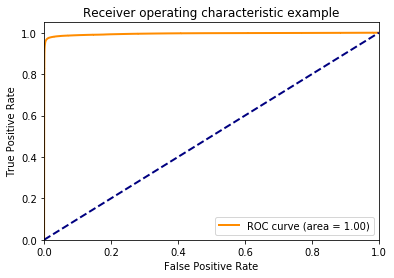

In [75]:
#Metrics
tes_first_neuron = [item[0] for item in df['real_class']] #get the first bit
print(len(tes_first_neuron))
print(len(df['score']))
predict_data = df

#predict_data['order'] = [fix_format(x) for x in predict_data['order']]

#function that calculate all metrics
df_misclassified = metrics_DNN(predict_data['order'], predict_data['pid'], tes_first_neuron,classes,predict_data['score'])


In [77]:
df_misclassified.to_csv('output_data/'+'ensemble_misclassified_data_'+classes[0]+'_'+classes[1]+'.tsv',index=False,sep='\t')